# **From Scratch Learning -1st Dataset**

## Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("fantacher/neu-metal-surface-defects-data")

root_dir = "/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data"
print("Path to dataset files:", root_dir)

100%|██████████| 57.4M/57.4M [00:00<00:00, 176MB/s]

Extracting files...


Path to dataset files: /kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data


## Transform Images

In [4]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

g = torch.Generator().manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.ImageFolder(root=os.path.join(root_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(root_dir, 'valid'), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(root_dir, 'test'), transform=transform)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    worker_init_fn=seed_worker, generator=g
)

val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    worker_init_fn=seed_worker, generator=g
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    worker_init_fn=seed_worker, generator=g
)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'

## Neural Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_prob)

        self.fc1  = nn.Linear(64 * 4 * 4, 64)
        self.fc2  = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv -> BN -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## Training - Validation

In [ ]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs,model_save_name):
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss = val_loss / len(valid_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Save best model state
    torch.save(best_model_state, f'{model_save_name}.pth')

    return train_losses, val_losses


In [ ]:
# Train and get losses
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50,model_save_name='Neu_scratch')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Create a list of epoch numbers starting from 1
epochs = range(1, len(train_losses) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='green', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss 1st dataset')
plt.legend()

# Ensure x-axis ticks are at integer epoch numbers
plt.xticks(epochs, rotation=90)

plt.show()

In [ ]:
# Find the minimum validation loss and its epoch
min_val_loss = min(val_losses)
min_epoch = val_losses.index(min_val_loss) + 1  # +1 because epochs start at 1

print(f"Minimum validation loss: {min_val_loss:.4f} at epoch {min_epoch}")

## Testing

In [ ]:
# Load best weights before testing
model.load_state_dict(torch.load('Neu_scratch.pth'))

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100*correct / total:.4f}%")


In [ ]:
test_model(model,test_loader)

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 64, 64))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes  # Automatically extracted from folder names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Greens, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))

## Visualizations

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# dummy_input = torch.randn(1, 1, 64, 64).to(device)
# writer.add_graph(model, dummy_input)
# writer.close()

In [ ]:
# !pip install tensorboard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=runs

In [ ]:
import matplotlib.pyplot as plt

# Visualize weights of first conv layer
weights = model.conv1.weight.data.cpu()  # shape: (out_channels, in_channels, kH, kW)

fig, axes = plt.subplots(1, weights.shape[0], figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(weights[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


# Visualize feature maps for one input image
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.bn1(model.conv1(x))      # first conv layer + batch norm (before relu/pool)
        x = x.cpu().squeeze(0)              # remove batch dim

    fig, axes = plt.subplots(1, x.shape[0], figsize=(15,5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Visualize weights of first conv layer
weights = model.conv2.weight.data.cpu()  # shape: (out_channels, in_channels, kH, kW)

fig, axes = plt.subplots(1, weights.shape[0], figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(weights[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


# Visualize feature maps for one input image
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.bn2(model.conv2(x))      # second conv layer + batch norm (before relu/pool)
        x = x.cpu().squeeze(0)              # remove batch dim

    fig, axes = plt.subplots(1, x.shape[0], figsize=(15,5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Visualize weights of first conv layer
weights = model.conv3.weight.data.cpu()  # shape: (out_channels, in_channels, kH, kW)

fig, axes = plt.subplots(1, weights.shape[0], figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(weights[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


# Visualize feature maps for one input image
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.bn3(model.conv3(x))      # third conv layer + batch norm (before relu/pool)
        x = x.cpu().squeeze(0)              # remove batch dim

    fig, axes = plt.subplots(1, x.shape[0], figsize=(15,5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Visualize weights of first conv layer
weights = model.conv4.weight.data.cpu()  # shape: (out_channels, in_channels, kH, kW)

fig, axes = plt.subplots(1, weights.shape[0], figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(weights[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


# Visualize feature maps for one input image
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.bn4(model.conv4(x))      # forth conv layer + batch norm (before relu/pool)
        x = x.cpu().squeeze(0)              # remove batch dim

    fig, axes = plt.subplots(1, x.shape[0], figsize=(15,5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    plt.show()


In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))

# Run a batch through the model
images, labels = next(iter(test_loader))
images = images.to(device)
output = model(images)

# activation['conv1'] now holds the feature maps of conv1
act = activation['conv1'][0].cpu()  # first image in batch

# Plot some feature maps
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))

# Run a batch through the model
images, labels = next(iter(test_loader))
images = images.to(device)
output = model(images)

# activation['conv2'] now holds the feature maps of conv2
act = activation['conv2'][0].cpu()  # first image in batch

# Plot some feature maps
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv3.register_forward_hook(get_activation('conv3'))

# Run a batch through the model
images, labels = next(iter(test_loader))
images = images.to(device)
output = model(images)

# activation['conv3'] now holds the feature maps of conv2
act = activation['conv3'][0].cpu()  # first image in batch

# Plot some feature maps
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv4.register_forward_hook(get_activation('conv4'))

# Run a batch through the model
images, labels = next(iter(test_loader))
images = images.to(device)
output = model(images)

# activation['conv4'] now holds the feature maps of conv4
act = activation['conv4'][0].cpu()  # first image in batch

# Plot some feature maps
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# **Transfer Learning - 1 fc layer unfreezed**

## Load Dataset

In [8]:
# Clone dataset repo
!git clone https://github.com/Fighter20092392/X-SDD-A-New-benchmark.git

data_dir = '/content/X-SDD-A-New-benchmark/X-SDD/datas'

# Then use this data_dir for your ImageFolder dataset

fatal: destination path 'X-SDD-A-New-benchmark' already exists and is not an empty directory.


## Transform Images

In [9]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

g = torch.Generator().manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load entire dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split into train(70%), val(15%), test(15%)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

new_train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    worker_init_fn=seed_worker, generator=g
)

new_val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    worker_init_fn=seed_worker, generator=g
)

new_test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    worker_init_fn=seed_worker, generator=g
)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")
print(f"Classes: {full_dataset.classes}")

Train size: 951, Val size: 204, Test size: 205
Classes: ['finishing roll printing', 'iron sheet ash', 'oxide scale of plate system', 'oxide scale of temperature system', 'red iron', 'slag inclusion', 'surface scratch']


## Neural Network Architecture

In [10]:
for name, param in model.named_parameters():
    if "fc2" not in name:  # freeze all except the last layer
        param.requires_grad = False
    else:
        param.requires_grad = True

num_new_classes = 7


model.fc2 = nn.Linear(64, num_new_classes).to(device)

# Ensure only this new layer's params require gradients
for param in model.fc2.parameters():
    param.requires_grad = True

NameError: name 'model' is not defined

## Training - Validation

In [ ]:
import torch.nn as nn
import torch

# Ensuring that if the dataset is imbalanced will be fixed
original_dataset = new_train_loader.dataset.dataset
class_names = original_dataset.classes
num_classes = len(class_names)

# Calculate class counts from the training subset
class_counts = [0] * num_classes
for _, label in new_train_loader:
    # The labels in the DataLoader correspond to the indices in the original dataset's classes
    for l in label:
        class_counts[l] += 1


total_count = sum(class_counts)
# Handle cases where a class might have zero samples in the training split
class_weights = [total_count / class_count if class_count > 0 else 0 for class_count in class_counts]

# Ensure class weights are positive for classes with samples
class_weights = [weight if weight > 0 else 1.0 for weight in class_weights] # Assign a small weight or 1 to empty classes if needed

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use these weights with the loss function
criterion_imbalanced = nn.CrossEntropyLoss(weight=class_weights)

print("Class Counts:", class_counts)
print("Calculated Class Weights:", class_weights)

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002)

In [ ]:
# Load new data and train as usual
train_losses_SDD, val_losses_SDD=train_model(model, new_train_loader, new_val_loader, criterion_imbalanced, optimizer, epochs=50,model_save_name='SDD_Tr_1lyr')

In [ ]:
epochs = range(1, len(train_losses_SDD) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_SDD, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses_SDD, label='Validation Loss', color='pink', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss 2nd dataset with Transfer Learning')
plt.legend()

# Ensure x-axis ticks are at integer epoch numbers
plt.xticks(epochs, rotation=90)


plt.show()

In [ ]:
# Find the minimum validation loss and its epoch
min_val_loss_SDD = min(val_losses_SDD)
min_epoch_SDD_trans = val_losses_SDD.index(min_val_loss_SDD) + 1  # +1 because epochs start at 1

print(f"Minimum validation loss for the 2nd dataset with transfer learning: {min_val_loss_SDD:.4f} at epoch {min_epoch_SDD_trans}")

## Testing

In [ ]:
# Load best weights before testing
model.load_state_dict(torch.load('SDD_Tr_1lyr.pth'))

In [ ]:
test_model(model,new_test_loader)

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in new_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes  # Automatically extracted from folder names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Purples, xticks_rotation=90)
plt.title("Confusion Matrix SDD Dataset - Transfer Learning")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))

# **Transfer Learning - 2 fcs unfreezed**

## Neural Network Architecture

In [136]:
model = CNN(num_classes=6).to(device)
model.load_state_dict(torch.load('Neu_scratch.pth'))


for name, param in model.named_parameters():
    if "fc2" not in name:
        param.requires_grad = False
    elif "fc1" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

num_new_classes = 7

model.fc1 = nn.Linear(64 * 4 * 4, 64).to(device)
model.fc2 = nn.Linear(64, num_new_classes).to(device)

# Ensure only this new layer's params require gradients
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True

## Training - Validation

In [137]:
import torch.nn as nn
import torch

# Ensuring that if the dataset is imbalanced will be fixed
original_dataset = new_train_loader.dataset.dataset
class_names = original_dataset.classes
num_classes = len(class_names)

# Calculate class counts from the training subset
class_counts = [0] * num_classes
for _, label in new_train_loader:
    # The labels in the DataLoader correspond to the indices in the original dataset's classes
    for l in label:
        class_counts[l] += 1


total_count = sum(class_counts)
# Handle cases where a class might have zero samples in the training split
class_weights = [total_count / class_count if class_count > 0 else 0 for class_count in class_counts]

# Ensure class weights are positive for classes with samples
class_weights = [weight if weight > 0 else 1.0 for weight in class_weights] # Assign a small weight or 1 to empty classes if needed

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use these weights with the loss function
criterion_imbalanced = nn.CrossEntropyLoss(weight=class_weights)

print("Class Counts:", class_counts)
print("Calculated Class Weights:", class_weights)

Class Counts: [137, 82, 40, 143, 279, 172, 98]
Calculated Class Weights: tensor([ 6.9416, 11.5976, 23.7750,  6.6503,  3.4086,  5.5291,  9.7041])


In [138]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002)

In [139]:
# Load new data and train as usual
train_losses_SDD, val_losses_SDD=train_model(model, new_train_loader, new_val_loader, criterion_imbalanced, optimizer, epochs=50,model_save_name='SDD_Tr_2lyr')

Epoch 1, Train Loss: 1.6023, Val Loss: 1.0974, Train Acc: 0.4816, Val Acc: 0.7304
Epoch 2, Train Loss: 1.1670, Val Loss: 0.8313, Train Acc: 0.6425, Val Acc: 0.7990
Epoch 3, Train Loss: 1.1005, Val Loss: 0.7349, Train Acc: 0.6414, Val Acc: 0.7941
Epoch 4, Train Loss: 0.9488, Val Loss: 0.6171, Train Acc: 0.7056, Val Acc: 0.8235
Epoch 5, Train Loss: 0.8392, Val Loss: 0.5825, Train Acc: 0.7119, Val Acc: 0.8039
Epoch 6, Train Loss: 0.7815, Val Loss: 0.5640, Train Acc: 0.7203, Val Acc: 0.8235
Epoch 7, Train Loss: 0.7857, Val Loss: 0.5411, Train Acc: 0.7319, Val Acc: 0.8333
Epoch 8, Train Loss: 0.7506, Val Loss: 0.5637, Train Acc: 0.7319, Val Acc: 0.8382
Epoch 9, Train Loss: 0.6975, Val Loss: 0.5146, Train Acc: 0.7655, Val Acc: 0.8284
Epoch 10, Train Loss: 0.6611, Val Loss: 0.5175, Train Acc: 0.7624, Val Acc: 0.8088
Epoch 11, Train Loss: 0.6350, Val Loss: 0.4726, Train Acc: 0.7645, Val Acc: 0.8235
Epoch 12, Train Loss: 0.6427, Val Loss: 0.5373, Train Acc: 0.7718, Val Acc: 0.8137
Epoch 13, Tra

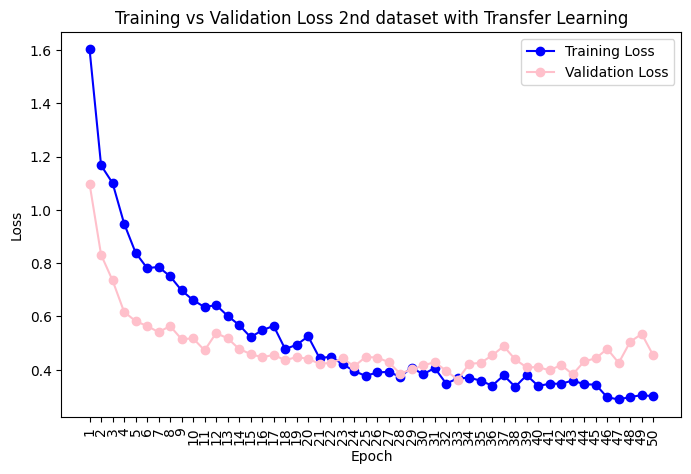

In [140]:
epochs = range(1, len(train_losses_SDD) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_SDD, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses_SDD, label='Validation Loss', color='pink', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss 2nd dataset with Transfer Learning')
plt.legend()
# Ensure x-axis ticks are at integer epoch numbers
plt.xticks(epochs, rotation=90)


plt.show()

In [141]:
# Find the minimum validation loss and its epoch
min_val_loss_SDD = min(val_losses_SDD)
min_epoch_SDD_trans = val_losses_SDD.index(min_val_loss_SDD) + 1  # +1 because epochs start at 1

print(f"Minimum validation loss for the 2nd dataset with transfer learning: {min_val_loss_SDD:.4f} at epoch {min_epoch_SDD_trans}")

Minimum validation loss for the 2nd dataset with transfer learning: 0.3627 at epoch 33


## Testing

In [145]:
# Load best weights before testing
model.load_state_dict(torch.load('SDD_Tr_2lyr.pth'))

<All keys matched successfully>

In [146]:
test_model(model,new_test_loader)

Test Accuracy: 86.3415%


In [147]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in new_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

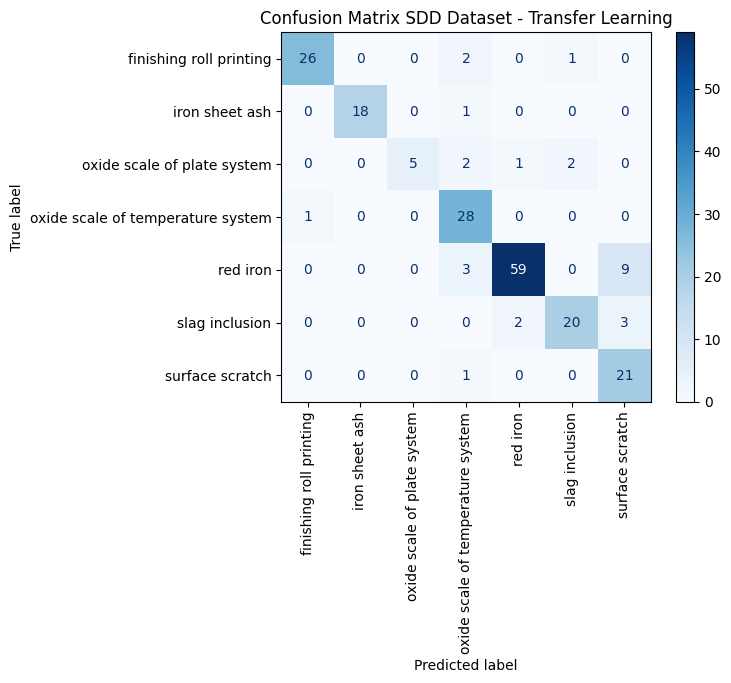

                                   precision    recall  f1-score   support

          finishing roll printing       0.96      0.90      0.93        29
                   iron sheet ash       1.00      0.95      0.97        19
      oxide scale of plate system       1.00      0.50      0.67        10
oxide scale of temperature system       0.76      0.97      0.85        29
                         red iron       0.95      0.83      0.89        71
                   slag inclusion       0.87      0.80      0.83        25
                  surface scratch       0.64      0.95      0.76        22

                         accuracy                           0.86       205
                        macro avg       0.88      0.84      0.84       205
                     weighted avg       0.89      0.86      0.86       205



In [148]:
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes  # Automatically extracted from folder names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix SDD Dataset - Transfer Learning")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))

# **From Scratch Learning - 2nd Dataset**

## Training - Validation

In [151]:
model2 = CNN(num_classes=7).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.0005)
train_losses_SDD_fromscratch, val_losses_SDD_fromscratch = train_model(model2, new_train_loader, new_val_loader, criterion_imbalanced, optimizer2, epochs=50,model_save_name='SDD_Scratch')

Epoch 1, Train Loss: 1.8077, Val Loss: 1.9632, Train Acc: 0.3123, Val Acc: 0.1814
Epoch 2, Train Loss: 1.5667, Val Loss: 1.5445, Train Acc: 0.4385, Val Acc: 0.5147
Epoch 3, Train Loss: 1.4382, Val Loss: 1.2332, Train Acc: 0.4890, Val Acc: 0.6716
Epoch 4, Train Loss: 1.2403, Val Loss: 1.0920, Train Acc: 0.5825, Val Acc: 0.6814
Epoch 5, Train Loss: 1.0740, Val Loss: 0.9172, Train Acc: 0.6519, Val Acc: 0.7745
Epoch 6, Train Loss: 0.9630, Val Loss: 0.8699, Train Acc: 0.6845, Val Acc: 0.7353
Epoch 7, Train Loss: 0.8775, Val Loss: 0.8631, Train Acc: 0.7066, Val Acc: 0.7010
Epoch 8, Train Loss: 0.7438, Val Loss: 0.6445, Train Acc: 0.7560, Val Acc: 0.8088
Epoch 9, Train Loss: 0.6627, Val Loss: 0.6051, Train Acc: 0.8013, Val Acc: 0.8186
Epoch 10, Train Loss: 0.5828, Val Loss: 0.5457, Train Acc: 0.8128, Val Acc: 0.8333
Epoch 11, Train Loss: 0.5365, Val Loss: 0.4558, Train Acc: 0.8181, Val Acc: 0.8431
Epoch 12, Train Loss: 0.4782, Val Loss: 0.4570, Train Acc: 0.8370, Val Acc: 0.8480
Epoch 13, Tra

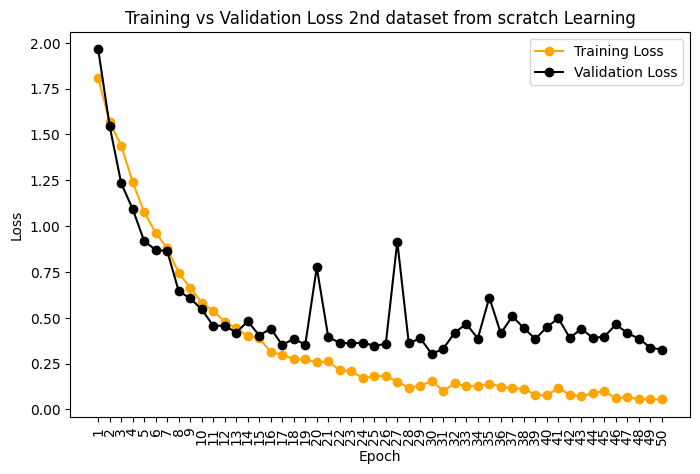

In [152]:
epochs = range(1, len(train_losses_SDD_fromscratch) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_SDD_fromscratch, label='Training Loss', color='orange', marker='o')
plt.plot(epochs, val_losses_SDD_fromscratch, label='Validation Loss', color='black', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss 2nd dataset from scratch Learning')
plt.legend()

# Ensure x-axis ticks are at integer epoch numbers
plt.xticks(epochs, rotation=90)

plt.show()

In [153]:
# Find the minimum validation loss and its epoch
min_val_loss_SDD = min(val_losses_SDD_fromscratch)
min_epoch_SDD_scratch = val_losses_SDD_fromscratch.index(min_val_loss_SDD) + 1  # +1 because epochs start at 1

print(f"Minimum validation loss for the 2nd dataset with transfer learning: {min_val_loss_SDD:.4f} at epoch {min_epoch_SDD_scratch}")

Minimum validation loss for the 2nd dataset with transfer learning: 0.3018 at epoch 30


## Testing

In [154]:
model2.load_state_dict(torch.load('SDD_Scratch.pth'))

<All keys matched successfully>

In [155]:
test_model(model2,new_test_loader)


Test Accuracy: 92.1951%


In [157]:
model2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in new_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

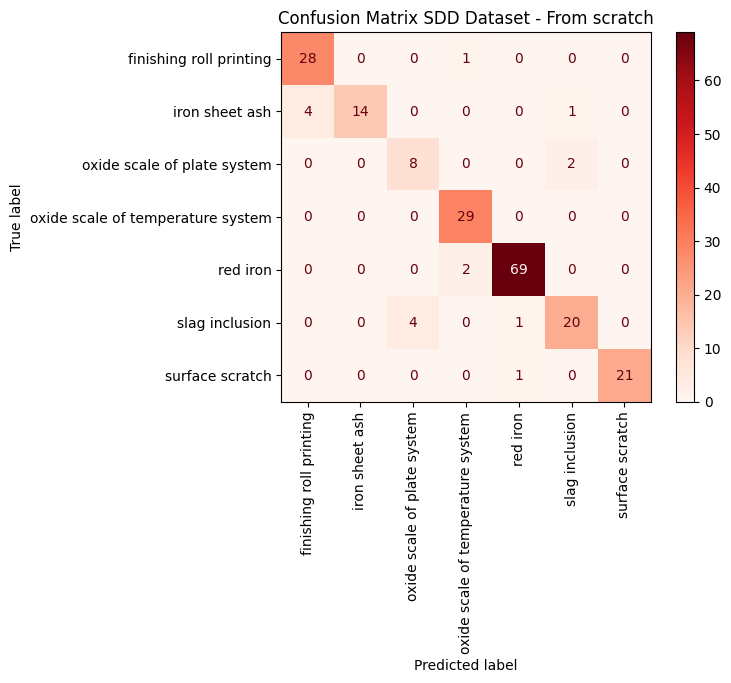

                                   precision    recall  f1-score   support

          finishing roll printing       0.88      0.97      0.92        29
                   iron sheet ash       1.00      0.74      0.85        19
      oxide scale of plate system       0.67      0.80      0.73        10
oxide scale of temperature system       0.91      1.00      0.95        29
                         red iron       0.97      0.97      0.97        71
                   slag inclusion       0.87      0.80      0.83        25
                  surface scratch       1.00      0.95      0.98        22

                         accuracy                           0.92       205
                        macro avg       0.90      0.89      0.89       205
                     weighted avg       0.93      0.92      0.92       205



In [158]:
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes  # Automatically extracted from folder names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)
plt.title("Confusion Matrix SDD Dataset - From scratch")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))